# **This Assignment is done by N M Emran Hussain, GWID:24414095**

### Getting started

In [56]:
# Libraries for data analysis and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')                 # visual style for seaborn images

# for data processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# for model imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

# for Model Evaluation
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             auc,
                             roc_curve,
                             roc_auc_score,
                             recall_score,
                             precision_score,
                             f1_score,
                             roc_auc_score,
                             mean_squared_error,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             r2_score )

import warnings
warnings.simplefilter("ignore")

### Loading Datasets

In [57]:
df_Feb = pd.read_csv('202402-capitalbikeshare-tripdata.csv')
df_Mar = pd.read_csv('202403-capitalbikeshare-tripdata.csv')
df_Apr = pd.read_csv('202404-capitalbikeshare-tripdata.csv')

# Merge the csv files
df=pd.concat([df_Feb, df_Mar,df_Apr])

### Let's consider the GWSB station "22nd & H St NW"

### Bike Availability: Number of Pickups

In [58]:
# Convert the 'started_at' column to datetime objects
df['started_at_date'] = pd.to_datetime(df['started_at']).dt.date

# Filter for trips started at '22nd & H St NW'
PU_trips = df[df['start_station_name'] == '22nd & H St NW']

# Group by date and count the trips
PU_counts = PU_trips.groupby('started_at_date')['started_at_date'].count()

PU_counts

started_at_date
2024-02-01    33
2024-02-02    23
2024-02-03    22
2024-02-04    18
2024-02-05    19
              ..
2024-04-26    33
2024-04-27    18
2024-04-28    36
2024-04-29    37
2024-04-30    40
Name: started_at_date, Length: 90, dtype: int64

### Dock Availability: Number of Dropoffs

In [59]:
# Convert the 'ended_at' column to datetime objects
df['ended_at_date'] = pd.to_datetime(df['ended_at']).dt.date

# Filter for trips ended at '22nd & H St NW'
DO_trips = df[df['end_station_name'] == '22nd & H St NW']

# Group by date and count the trips
DO_counts = DO_trips.groupby('ended_at_date')['ended_at_date'].count()

DO_counts

ended_at_date
2024-02-01    33
2024-02-02    25
2024-02-03    20
2024-02-04    19
2024-02-05    23
              ..
2024-04-26    39
2024-04-27    24
2024-04-28    28
2024-04-29    38
2024-04-30    39
Name: ended_at_date, Length: 90, dtype: int64

### Merge PU and DO tables
- For each day, we look at the numbers of pickups and dropoffs

In [60]:
# merge PU_counts and DO_counts by matching the dates, and change the column names to PU_count and DO_count respectively.

PU_DO_counts = pd.merge(PU_counts, DO_counts, left_index=True, right_index=True, how='outer')
PU_DO_counts = PU_DO_counts.rename(columns={'started_at_date': 'PU_ct', 'ended_at_date': 'DO_ct'})

# change the index name from 'started_at' to 'date'

PU_DO_counts = PU_DO_counts.rename_axis('date')
PU_DO_counts

,PU_ct,DO_ct
date,,
2024-02-01,33,33
2024-02-02,23,25
2024-02-03,22,20
2024-02-04,18,19
2024-02-05,19,23
...,...,...
2024-04-26,33,39
2024-04-27,18,24
2024-04-28,36,28


### Feature Information: Weather Data

In [61]:
df_weather = pd.read_csv('DC_weather_2024.csv')
df_weather.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"washington, dc",2024-01-01,43.0,38.9,40.8,41.8,31.4,36.4,33.3,74.7,...,0.9,1,10,2024-01-01T07:26:50,2024-01-01T16:56:30,0.68,Overcast,Cloudy skies throughout the day.,cloudy,"KDCA,72405013743,D6279,72403793728,KADW,KDAA,7..."
1,"washington, dc",2024-01-02,45.9,35.7,40.4,40.9,27.2,33.8,26.2,57.3,...,8.3,5,10,2024-01-02T07:26:58,2024-01-02T16:57:20,0.72,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,D6279,72403793728,KADW,KDAA,7..."
2,"washington, dc",2024-01-03,47.8,33.7,39.9,44.6,27.8,36.4,26.6,59.5,...,9.6,5,10,2024-01-03T07:27:04,2024-01-03T16:58:10,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"C6294,KDCA,72405013743,D6279,72403793728,KADW,..."
3,"washington, dc",2024-01-04,46.7,33.2,40.4,41.9,24.1,34.6,25.2,55.2,...,4.8,4,10,2024-01-04T07:27:07,2024-01-04T16:59:02,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"C6294,KDCA,72405013743,72403793728,KADW,KDAA,7..."
4,"washington, dc",2024-01-05,39.9,27.8,33.6,35.8,19.4,28.0,18.9,55.0,...,11.6,5,10,2024-01-05T07:27:09,2024-01-05T16:59:55,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"C6294,KDCA,72405013743,72403793728,D6279,KADW,..."


### Drop variables of your choice

In [62]:
# Drop unnecessary variables
df_weather=df_weather.drop(columns=['name', 'stations','description','sunrise','sunset','conditions','severerisk','preciptype','windgust'])

### Prepare X and y: Merge df_weather with PU_DO_counts

In [63]:
# Convert the 'datetime' column to datetime objects and extract the date
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather['date'] = df_weather['datetime'].dt.date

# Merge the two dataframes based on the 'date' column
merged_df = pd.merge(PU_DO_counts, df_weather, on='date', how='left')

### Prepare training and test data

In [64]:
# we have two target variables: PU_ct and DO_ct
y = merged_df[['PU_ct','DO_ct']]
X_all = merged_df.drop(columns=['PU_ct','DO_ct']) # all features
X_all

,date,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon
0,2024-02-01,2024-02-01,53.0,31.7,42.4,53.0,26.4,39.3,34.0,74.0,...,12.0,190.8,1016.3,43.3,8.4,136.8,11.8,5,0.73,partly-cloudy-day
1,2024-02-02,2024-02-02,51.8,44.0,47.1,51.8,36.6,44.4,35.5,65.1,...,19.1,354.3,1012.8,97.3,9.8,51.7,4.4,2,0.75,rain
2,2024-02-03,2024-02-03,51.0,35.8,42.2,51.0,28.0,37.6,26.2,53.8,...,14.7,354.9,1018.2,11.0,9.9,143.9,12.5,6,0.79,clear-day
3,2024-02-04,2024-02-04,51.2,32.7,41.7,51.2,27.4,40.7,26.0,56.4,...,9.2,87.4,1016.0,9.0,9.9,147.4,12.8,6,0.83,clear-day
4,2024-02-05,2024-02-05,51.8,32.5,41.0,51.8,26.0,37.8,26.0,57.4,...,12.2,34.9,1013.8,21.4,9.9,145.3,12.7,6,0.86,partly-cloudy-day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2024-04-26,2024-04-26,64.9,45.5,55.2,64.9,41.5,54.2,34.9,50.8,...,15.4,116.4,1029.5,69.1,9.9,215.0,18.5,9,0.59,partly-cloudy-day
86,2024-04-27,2024-04-27,60.1,51.9,55.7,60.1,51.9,55.7,45.4,69.0,...,10.0,149.9,1030.1,97.3,9.7,44.0,3.9,2,0.63,rain
87,2024-04-28,2024-04-28,83.1,55.8,67.0,83.3,55.8,67.1,56.4,70.6,...,10.0,170.0,1021.3,62.1,9.8,213.6,18.5,9,0.67,partly-cloudy-day
88,2024-04-29,2024-04-29,88.3,62.7,75.2,88.9,62.7,75.3,60.9,63.5,...,13.0,177.3,1015.6,35.8,9.9,204.5,17.8,9,0.70,partly-cloudy-day


### Reduce dimensions by feature type

In [65]:
# Dimentionality reduction: PCA
def dim_red(dataframe,lists,columnname):
    #extract the columns
    datagroup=dataframe.filter(lists)
    #normalize the data
    from sklearn.preprocessing import StandardScaler
    data_norm = StandardScaler().fit_transform(datagroup)
    #feature extraction with PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=1)
    PCs = pca.fit_transform(datagroup)

    df_pca = pd.DataFrame(data = PCs, columns = [columnname])
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    return df_pca

In [66]:
temp_group=['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike','dew']
precip_group=['humidity','precip', 'precipprob', 'precipcover']
vis_group=['visibility','solarradiation', 'solarenergy', 'uvindex']
wind_group=['windgust','windspeed', 'winddir']

In [67]:
temp_PC1=dim_red(X_all,temp_group,'temp_PC1')
precip_PC1=dim_red(X_all,precip_group,'precip_PC1')
vis_PC1=dim_red(X_all,vis_group,'vis_PC1')
wind_PC1=dim_red(X_all,wind_group,'wind_PC1')

Explained variation per principal component: [0.88019868]
Explained variation per principal component: [0.91381372]
Explained variation per principal component: [0.99964556]
Explained variation per principal component: [0.99815594]


### Dimension reduction on the features
- Now we call the following features X

In [68]:
X = pd.concat([temp_PC1,precip_PC1,vis_PC1,wind_PC1],axis = 1)
X

,temp_PC1,precip_PC1,vis_PC1,wind_PC1
0,-23.616810,-32.623727,4.466466,-0.835152
1,-11.905681,62.494225,-80.995297,162.790919
2,-26.760771,-36.797274,11.641535,163.281210
3,-26.853470,-36.260085,15.152105,-104.272810
4,-28.487066,-36.053473,13.052631,-156.681869
...,...,...,...,...
85,7.209137,-37.417107,83.053732,-75.127468
86,14.738853,63.300059,-88.705521,-41.772262
87,47.863874,-33.326205,81.659100,-21.678490
88,65.008395,-34.793145,72.539192,-14.306077


### <font color="red"> Important: train_test_split with y=['PU_ct','DO_ct']. Why? <font>

In [69]:
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.4, random_state = 200) # 40% test data

# Checking the shapes
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Training targets shape: {y_train.shape}")
print(f"Test targets shape: {y_test.shape}")

Training features shape: (54, 4)
Test features shape: (36, 4)
Training targets shape: (54, 2)
Test targets shape: (36, 2)


In [70]:
y_train.head()

,PU_ct,DO_ct
73,26,24
60,26,22
18,10,15
44,19,20
4,19,23


# <font color="red"> Your code starts from here... </font>
- In this assignment, we first reduce the dimensions and then use only [temp_PC1,precip_PC1,vis_PC1,wind_PC1] for prediction.
- Follow the discussion and details in Lecture 6.
- Based on the analysis and result, summarize a 5-page final report in PDF.
- Submit the final report with Python file.

## Explanatory Data Analysis

### Visualize Number of available bike/pickups (PU_ct) and Number of available docks/dropoffs (DO_ct)

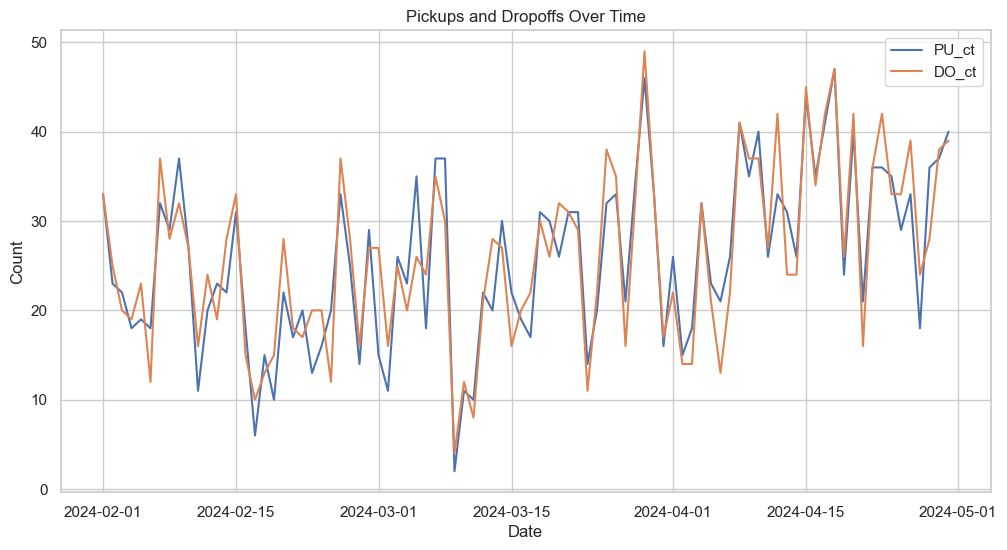

In [72]:
# plot line chart showing the PU_count and DO_count over time
import matplotlib.pyplot as plt

# Create the line chart
plt.figure(figsize=(12, 6))
plt.plot(PU_DO_counts.index, PU_DO_counts['PU_ct'], label='PU_ct')
plt.plot(PU_DO_counts.index, PU_DO_counts['DO_ct'], label='DO_ct')

# Customize the chart
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Pickups and Dropoffs Over Time')
plt.legend()
plt.grid(True)

plt.show()

### Visualizing pickups and dropoffs from the prespective of weather data

#### For Number of Available Pick-ups/Bikes (PU_ct)

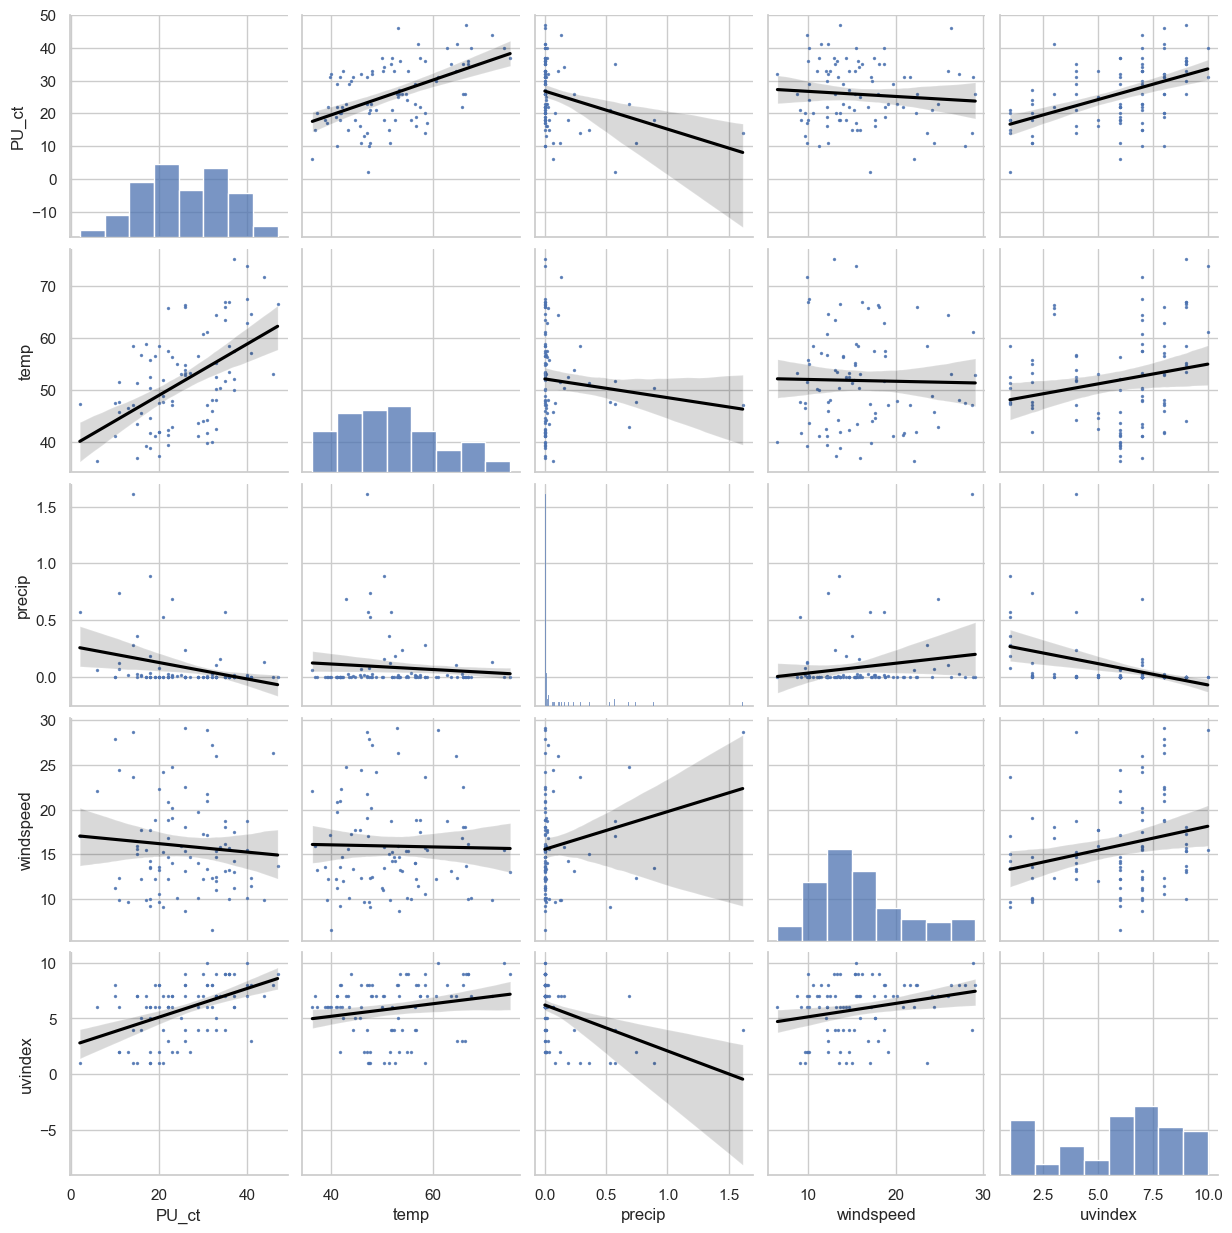

In [74]:
import seaborn as sns
sns.pairplot(merged_df[['PU_ct',"temp", "precip", "windspeed","uvindex"]], kind="reg",plot_kws=dict(scatter_kws=dict(s=2), line_kws = {'color':'black'}))

#### For Number of Drop-offs/Available Docks (DO_ct)

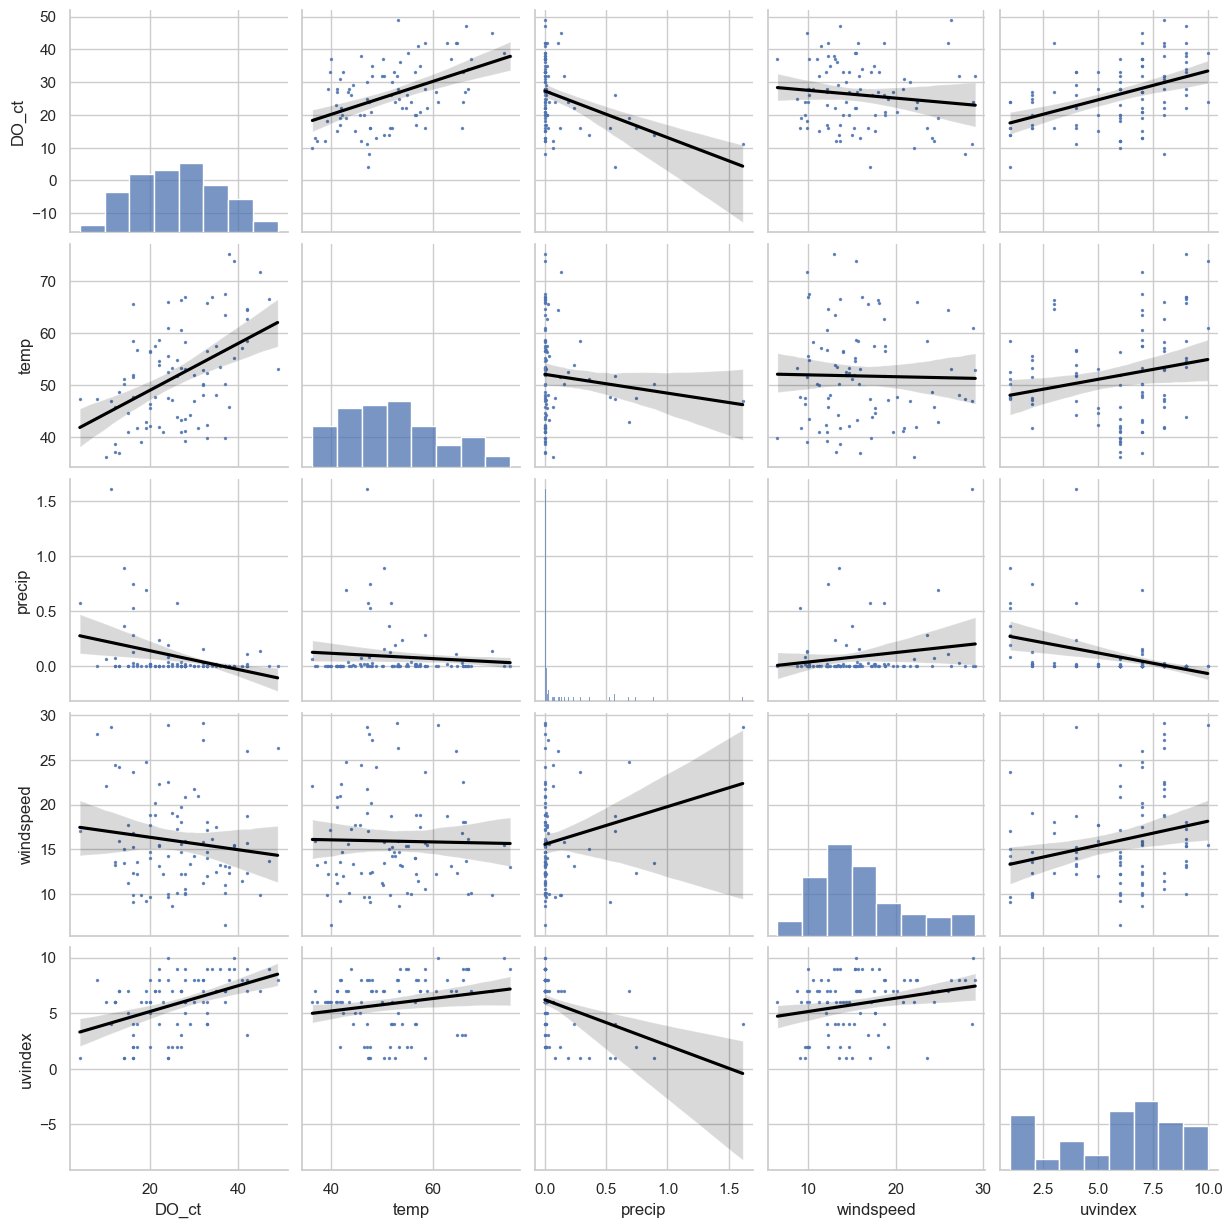

In [75]:
import seaborn as sns
sns.pairplot(merged_df[['DO_ct',"temp", "precip", "windspeed","uvindex"]], kind="reg",plot_kws=dict(scatter_kws=dict(s=2), line_kws = {'color':'black'}))

## Predictive Modeling

**We have to come up with a strategy here.** After business understanding and explanatory data analysis we will get prediction of Number of bikes available (PU_ct) and Number of docks available (DO_ct) using different **predictive models** like **'Linear Regression', 'Ridge Regression', 'LASSO', 'Elastic Net', 'KNN', 'Regression tree', 'Random Forest', 'Gradient Boosting' and 'Neural Network.** We will calculate **hyperparameter tuning** **individually and separately** suitable for each model and We will also calculate **MSE for PU_ct and DO_ct separately** for each of the models mentioned above and finally we will calculate **Out-of-sample-cost for each models.**

### Linear Models

#### Linear Regression model

In [76]:
# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train['PU_ct'])  # Fit on PU_ct
lr.fit(X_train, y_train['DO_ct'])  # Fit on DO_ct

# Daily bike share predictions
lr_preds = lr.predict(X_test)

# Evaluate the Trained Models
print("Linear Regression Performance:")
print("MSE on PU_ct:", mean_squared_error(y_test['PU_ct'], lr.predict(X_test)))
print("MSE on DO_ct:", mean_squared_error(y_test['DO_ct'], lr.predict(X_test)))


Linear Regression Performance:
MSE on PU_ct: 54.88837165427776
MSE on DO_ct: 69.54655617514607


##### Hyperparameter Tuning with GridSearch CV for Ridge, LASSO and Elastic Net Models

In [35]:
# Define range of alpha values to test
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# GridSearchCV for Ridge Regression with 5-fold cross-validation
ridge_grid = GridSearchCV(Ridge(), param_grid, cv=5) #
ridge_grid.fit(X_train, y_train)
print(f"Best alpha for Ridge: {ridge_grid.best_params_}")

# GridSearchCV for Lasso Regression with 5-fold cross-validation
lasso_grid = GridSearchCV(Lasso(), param_grid, cv=5)
lasso_grid.fit(X_train, y_train)
print(f"Best alpha for Lasso: {lasso_grid.best_params_}")

# GridSearchCV for Elastic Net with 5-fold cross-validation
elastic_grid = GridSearchCV(ElasticNet(), param_grid, cv=5)
elastic_grid.fit(X_train, y_train)
print(f"Best alpha for Elastic Net: {elastic_grid.best_params_}")


Best alpha for Ridge: {'alpha': 100}
Best alpha for Lasso: {'alpha': 10}
Best alpha for Elastic Net: {'alpha': 100}


#### Ridge Model

In [79]:
# Train the Ridge Regression model
ridge_cv = Ridge(alpha=10)
ridge_cv.fit(X_train, y_train['PU_ct'])  # Fit on PU_ct
ridge_cv.fit(X_train, y_train['DO_ct'])  # Fit on DO_ct

# Daily bike share predictions
ridge_preds = ridge_cv.predict(X_test)

# Evaluate the Trained Models
print("Ridge Regression Performance:")
print("MSE on PU_ct:", mean_squared_error(y_test['PU_ct'], ridge_cv.predict(X_test)))
print("MSE on DO_ct:", mean_squared_error(y_test['DO_ct'], ridge_cv.predict(X_test)))

Ridge Regression Performance:
MSE on PU_ct: 54.889102324533944
MSE on DO_ct: 69.54546851075486


#### LASSO Model

In [80]:
# Train the Lasso Regression
lasso_cv = Lasso(alpha=100)
lasso_cv.fit(X_train, y_train['PU_ct'])  # Fit on PU_ct
lasso_cv.fit(X_train, y_train['DO_ct'])  # Fit on DO_ct

# Daily bike share predictions
lasso_preds = lasso_cv.predict(X_test)

# Evaluate the Trained Models
print("Lasso Regression Performance:")
print("MSE on PU_ct:", mean_squared_error(y_test['PU_ct'], lasso_cv.predict(X_test)))
print("MSE on DO_ct:", mean_squared_error(y_test['DO_ct'], lasso_cv.predict(X_test)))


Lasso Regression Performance:
MSE on PU_ct: 71.55802986575186
MSE on DO_ct: 79.71254910380323


#### Elastic Net Model

In [81]:
# Train the Elastic Net Model
elastic_cv = ElasticNet(alpha=100)
elastic_cv.fit(X_train, y_train['PU_ct'])  # Fit on PU_ct
elastic_cv.fit(X_train, y_train['DO_ct'])  # Fit on DO_ct

# Daily bike share predictions
elastic_preds = elastic_cv.predict(X_test)

# Evaluate the Trained Models
print("Elastic Net Regression Performance:")
print("MSE on PU_ct:", mean_squared_error(y_test['PU_ct'], elastic_cv.predict(X_test)))
print("MSE on DO_ct:", mean_squared_error(y_test['DO_ct'], elastic_cv.predict(X_test)))

Elastic Net Regression Performance:
MSE on PU_ct: 62.55413922452007
MSE on DO_ct: 72.4992618119207


### Tree Based Models

#### Decision Tree

##### Hyperparameter Tuning

In [88]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Decision Tree hyperparameter tuning
tree_params = {'max_depth': range(1, 21)}
tree = DecisionTreeRegressor(random_state=0)
tree_cv = GridSearchCV(tree, tree_params, cv=5, scoring='r2')
tree_cv.fit(X_train, y_train['PU_ct'])
tree_cv.fit(X_train, y_train['DO_ct'])
print(f"Best max_depth for Decision Tree: {tree_cv.best_params_}")

Best max_depth for Decision Tree: {'max_depth': 1}


##### Training Decision Tree Using the Hyperparamter Tuning

In [104]:
# Training the decision tree
tree_tuned = DecisionTreeRegressor(max_depth=1)
tree_tuned.fit(X_train, y_train['PU_ct'])
tree_tuned.fit(X_train, y_train['DO_ct'])

# Daily bike share predictions
tree_preds = tree_tuned.predict(X_test)

# Evaluate the trained models
print("Decision Tree Performance:")
print("MSE on PU_ct:", mean_squared_error(y_test['PU_ct'], tree_tuned.predict(X_test)))
print("MSE on DO_ct:", mean_squared_error(y_test['DO_ct'], tree_tuned.predict(X_test)))


Decision Tree Performance:
MSE on PU_ct: 86.39507544581618
MSE on DO_ct: 95.92655692729765


#### Random Forest

##### Hyperparameter Tuning

In [91]:
# Random Forest Implementation with Proper Hyperparameter Tuning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from pprint import pprint

# Initialize Random Forest models
rf_pu = RandomForestRegressor(random_state=42)
rf_do = RandomForestRegressor(random_state=42)

# Hyperparameter Tuning Setup
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

# Fit the model and find best alphas
rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
rf.fit(X_train, y_train['PU_ct'])
rf.fit(X_train, y_train['DO_ct'])
print("Best Parameters for PU_ct:", rf.best_params_)
print("Best Parameters for DO_ct:", rf.best_params_)


Best Parameters for PU_ct: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best Parameters for DO_ct: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}


##### Training Random Forest Using the Hyperparamter Tuning

In [93]:
# Train with the best parameters
best_rf_pu = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=2, random_state=42)
best_rf_pu.fit(X_train, y_train['PU_ct'])
best_rf_do = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=2, random_state=42)
best_rf_do.fit(X_train, y_train['DO_ct'])

# Daily bike share predictions
rf_preds_pu = best_rf_pu.predict(X_test)
rf_preds_do = best_rf_do.predict(X_test)

# Evaluate the tuned models
print("Random Forest Performance:")
print("MSE on PU_ct:", mean_squared_error(y_test['PU_ct'], rf_preds_pu))
print("MSE on DO_ct:", mean_squared_error(y_test['DO_ct'], rf_preds_do))


Random Forest Performance:
MSE on PU_ct: 73.18879933879106
MSE on DO_ct: 85.36646732175146


#### Gradient Boosting 

##### Hyperparameter Tuning

In [45]:
# Gradient Boosting
gb = GradientBoostingRegressor()
gb_params = {'n_estimators': [50,100], 'learning_rate': [0.1,0.05]}
gb_cv = GridSearchCV(gb, gb_params, cv=5)
gb_cv.fit(X_train, y_train['PU_ct'])
gb_cv.fit(X_train, y_train['DO_ct'])
print(f"Best parameters for Gradient Boosting: {gb_cv.best_params_}")

Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'n_estimators': 50}


##### Training Gradient Boosting Using the Hyperparamter Tuning

In [97]:
# Training the Gradient Boost modelwith best parameters for Gradient Boosting: {'learning_rate': 0.05, 'n_estimators': 50}
gb_tuned = GradientBoostingRegressor(n_estimators=50, learning_rate=0.05)
gb_tuned.fit(X_train, y_train['PU_ct'])
gb_tuned.fit(X_train, y_train['DO_ct'])

# Daily bike share predictions
gb_preds = gb_tuned.predict(X_test)

# Evaluate the trained models
print("Gradient Boosting Performance:")
print("MSE on PU_ct:", mean_squared_error(y_test['PU_ct'], gb_tuned.predict(X_test)))
print("MSE on DO_ct:", mean_squared_error(y_test['DO_ct'], gb_tuned.predict(X_test)))


Gradient Boosting Performance:
MSE on PU_ct: 92.4546797386538
MSE on DO_ct: 111.94537133540767


### Non-linear Models

#### K-Nearest Neighbours (KNN) Model

##### Hyperparameter Tuning

In [47]:
# Train the K-nearest Neighbours
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn_params = {'n_neighbors': [5, 10, 15]}
knn_cv = GridSearchCV(knn, knn_params, cv=5)
knn_cv.fit(X_train, y_train['PU_ct'])
knn_cv.fit(X_train, y_train['DO_ct'])
print(f"Best n_neighbors for KNN: {knn_cv.best_params_}")


Best n_neighbors for KNN: {'n_neighbors': 10}


##### Training KNN model Using the Hyperparamter Tuning

In [101]:
# Training the K-nearest Neighbours with best n_neighbors for KNN: {'n_neighbors': 10}
knn_tuned = KNeighborsRegressor(n_neighbors=10)
knn_tuned.fit(X_train, y_train['PU_ct'])
knn_tuned.fit(X_train, y_train['DO_ct'])

# Daily Bike share predictions
knn_preds_pu = knn_tuned.predict(X_test)
knn_preds_do = knn_tuned.predict(X_test)

# Evaluate the trained models
print("K-nearest Neighbours Performance:")
print("MSE on PU_ct:", mean_squared_error(y_test['PU_ct'], knn_tuned.predict(X_test)))
print("MSE on DO_ct:", mean_squared_error(y_test['DO_ct'], knn_tuned.predict(X_test)))


K-nearest Neighbours Performance:
MSE on PU_ct: 64.92972222222222
MSE on DO_ct: 72.85194444444443


#### Neural Network Model

##### Hyperparameter Tuning

In [49]:
# Neural Network hyperparameter tuning
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

nn = MLPRegressor(random_state=42)
nn_params = {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.001, 0.01]}
nn_cv = GridSearchCV(nn, nn_params, cv=5)
nn_cv.fit(X_train, y_train['PU_ct'])
nn_cv.fit(X_train, y_train['DO_ct'])
print(f"Best parameters for Neural Network: {nn_cv.best_params_}")


Best parameters for Neural Network: {'alpha': 0.01, 'hidden_layer_sizes': (100,)}


##### Training Neural Network Model Using the Hyperparamter Tuning

In [103]:
# Train the Neural Network with best  parameters for Neural Network: {'alpha': 0.01, 'hidden_layer_sizes': (100,)}
nn_tuned = MLPRegressor(hidden_layer_sizes=(100,), alpha=0.01, random_state=42)
nn_tuned.fit(X_train, y_train['PU_ct'])
nn_tuned.fit(X_train, y_train['DO_ct'])

# Daily bike share predictions
nn_preds_pu = nn_tuned.predict(X_test)
nn_preds_do = nn_tuned.predict(X_test)


# Evaluate the tuned Neural Network fitted models
print("Neural Network Performance:")
print("MSE on PU_ct:", mean_squared_error(y_test['PU_ct'], nn_tuned.predict(X_test)))
print("MSE on DO_ct:", mean_squared_error(y_test['DO_ct'], nn_tuned.predict(X_test)))


Neural Network Performance:
MSE on PU_ct: 74.25971046755058
MSE on DO_ct: 100.55848434789118


## Performance Evaluation

In [136]:
# DataFrame of MSE values from all trained models
mse_data = {
    'Model': [
        'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net',
        'Decision Tree', 'Random Forest', 'Gradient Boosting',
        'K-nearest Neighbours', 'Neural Network'
    ],
    
    'MSE PU_ct': [
        mean_squared_error(y_test['PU_ct'], lr.predict(X_test)),
        mean_squared_error(y_test['PU_ct'], ridge_cv.predict(X_test)),
        mean_squared_error(y_test['PU_ct'], lasso_cv.predict(X_test)),
        mean_squared_error(y_test['PU_ct'], elastic_cv.predict(X_test)),
        mean_squared_error(y_test['PU_ct'], tree_tuned.predict(X_test)),
        mean_squared_error(y_test['PU_ct'], rf_preds_pu),
        mean_squared_error(y_test['PU_ct'], gb_tuned.predict(X_test)),
        mean_squared_error(y_test['PU_ct'], knn_tuned.predict(X_test)),
        mean_squared_error(y_test['PU_ct'], nn_tuned.predict(X_test))
    ],
    
    'MSE DO_ct': [
        mean_squared_error(y_test['DO_ct'], lr.predict(X_test)),
        mean_squared_error(y_test['DO_ct'], ridge_cv.predict(X_test)),
        mean_squared_error(y_test['DO_ct'], lasso_cv.predict(X_test)),
        mean_squared_error(y_test['DO_ct'], elastic_cv.predict(X_test)),
        mean_squared_error(y_test['DO_ct'], tree_tuned.predict(X_test)),
        mean_squared_error(y_test['DO_ct'], rf_preds_do),
        mean_squared_error(y_test['DO_ct'], gb_tuned.predict(X_test)),
        mean_squared_error(y_test['DO_ct'], knn_tuned.predict(X_test)),
        mean_squared_error(y_test['DO_ct'], nn_tuned.predict(X_test))
    ]
}

# Create DataFrame and display
results_df = pd.DataFrame(mse_data)
print(results_df)


                  Model  MSE PU_ct   MSE DO_ct
0     Linear Regression  54.888372   69.546556
1      Ridge Regression  54.889102   69.545469
2      Lasso Regression  71.558030   79.712549
3           Elastic Net  62.554139   72.499262
4         Decision Tree  86.395075   95.926557
5         Random Forest  73.188799   85.366467
6     Gradient Boosting  92.454680  111.945371
7  K-nearest Neighbours  64.929722   72.851944
8        Neural Network  74.259710  100.558484


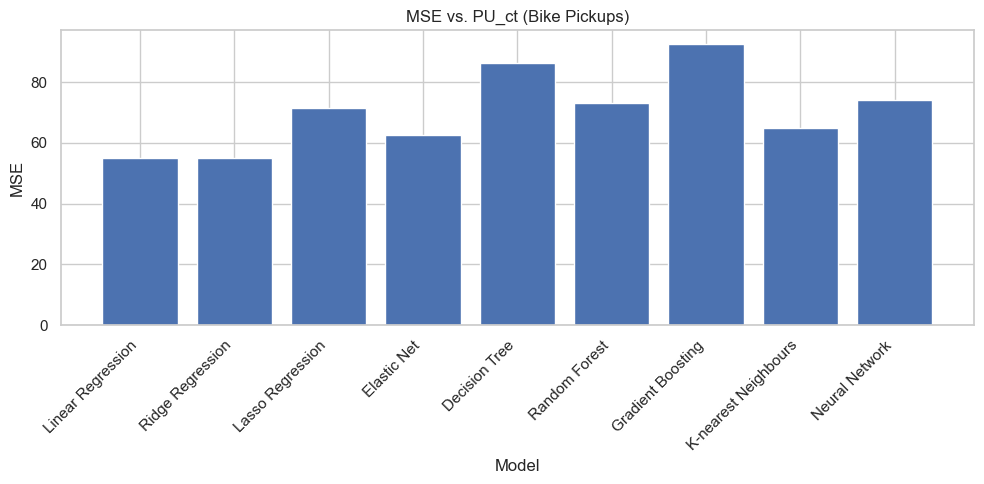

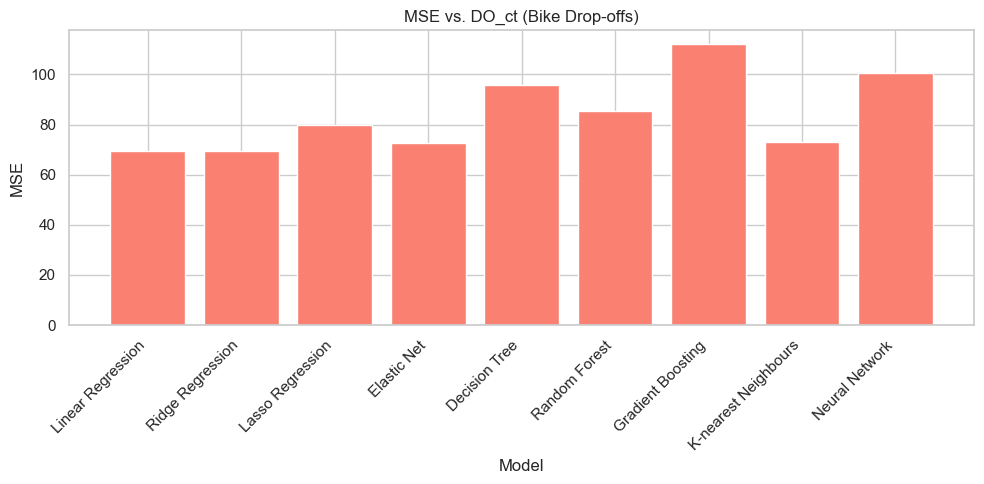

In [147]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Assume the following models are already trained and predictions are ready:
# lr, ridge_cv, lasso_cv, elastic_cv, tree_tuned, rf_preds_pu, rf_preds_do,
# gb_tuned, knn_tuned, nn_tuned

# Recalculate MSE values using models and predictions from earlier steps
mse_data = {
    'Model': [
        'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net',
        'Decision Tree', 'Random Forest', 'Gradient Boosting',
        'K-nearest Neighbours', 'Neural Network'
    ],

    'MSE_PU_ct': [
        mean_squared_error(y_test['PU_ct'], lr.predict(X_test)),
        mean_squared_error(y_test['PU_ct'], ridge_cv.predict(X_test)),
        mean_squared_error(y_test['PU_ct'], lasso_cv.predict(X_test)),
        mean_squared_error(y_test['PU_ct'], elastic_cv.predict(X_test)),
        mean_squared_error(y_test['PU_ct'], tree_tuned.predict(X_test)),
        mean_squared_error(y_test['PU_ct'], rf_preds_pu),
        mean_squared_error(y_test['PU_ct'], gb_tuned.predict(X_test)),
        mean_squared_error(y_test['PU_ct'], knn_tuned.predict(X_test)),
        mean_squared_error(y_test['PU_ct'], nn_tuned.predict(X_test))
    ],

    'MSE_DO_ct': [
        mean_squared_error(y_test['DO_ct'], lr.predict(X_test)),
        mean_squared_error(y_test['DO_ct'], ridge_cv.predict(X_test)),
        mean_squared_error(y_test['DO_ct'], lasso_cv.predict(X_test)),
        mean_squared_error(y_test['DO_ct'], elastic_cv.predict(X_test)),
        mean_squared_error(y_test['DO_ct'], tree_tuned.predict(X_test)),
        mean_squared_error(y_test['DO_ct'], rf_preds_do),
        mean_squared_error(y_test['DO_ct'], gb_tuned.predict(X_test)),
        mean_squared_error(y_test['DO_ct'], knn_tuned.predict(X_test)),
        mean_squared_error(y_test['DO_ct'], nn_tuned.predict(X_test))
    ]
}

# Create DataFrame
results_df = pd.DataFrame(mse_data)

# Plot MSE vs PU_ct
plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['MSE_PU_ct'])
plt.xticks(rotation=45, ha='right')
plt.title('MSE vs. PU_ct (Bike Pickups)')
plt.ylabel('MSE')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

# Plot MSE vs DO_ct
plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['MSE_DO_ct'], color = 'salmon')
plt.xticks(rotation=45, ha='right')
plt.title('MSE vs. DO_ct (Bike Drop-offs)')
plt.ylabel('MSE')
plt.xlabel('Model')
plt.tight_layout()
plt.show()


### Out-of-sample-cost for Linear Regression Model

In [133]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Set penalties
alpha = 2  # Unsuccessful pickup
beta = 3   # Unsuccessful drop-off
max_total = 17  # Total capacity = bikes + docks

# Train separate Linear Regression models
lr_pu = LinearRegression().fit(X_train, y_train['PU_ct'])
lr_do = LinearRegression().fit(X_train, y_train['DO_ct'])

# Predict on test set
pu_preds_lr = lr_pu.predict(X_test)
do_preds_lr = lr_do.predict(X_test)

# Initialize total costs
total_cost_test_y_all = []

# Loop through each test sample
for i in range(len(X_test)):
    min_total_cost = float('inf')
    optimal_x, optimal_y = None, None

    # Try all combinations where x + y = 17
    for x in range(max_total + 1):
        y = max_total - x

        total_cost = (
            alpha * max(0, pu_preds_lr[i] - x) +
            beta * max(0, do_preds_lr[i] - y)
        )

        if total_cost < min_total_cost:
            min_total_cost = total_cost
            optimal_x, optimal_y = x, y

    # Use optimal_x and optimal_y to compute cost on true y_test values
    true_pu = y_test.iloc[i]['PU_ct']
    true_do = y_test.iloc[i]['DO_ct']

    total_cost_test_y = (
        alpha * max(0, true_pu - optimal_x) +
        beta * max(0, true_do - optimal_y)
    )

    total_cost_test_y_all.append(total_cost_test_y)

# Calculate average out-of-sample cost
out_of_sample_avg_cost = sum(total_cost_test_y_all) / len(total_cost_test_y_all)
print(f"Out-of-sample average cost using Linear Regression model is: {out_of_sample_avg_cost:.4f}")


Out-of-sample average cost using Linear Regression model is: 76.6389


### Out-of-sample-cost for Ridge Regression Model

In [132]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

# Parameters
alpha_penalty = 2  # Penalty for unsuccessful pick-up
beta_penalty = 3   # Penalty for unsuccessful drop-off
max_total = 17     # Total capacity of bikes + docks

# Train separate Ridge models for PU_ct and DO_ct
ridge_pu = Ridge(alpha=10)
ridge_pu.fit(X_train, y_train['PU_ct'])

ridge_do = Ridge(alpha=10)
ridge_do.fit(X_train, y_train['DO_ct'])

# Make predictions
pu_preds_ridge = ridge_pu.predict(X_test)
do_preds_ridge = ridge_do.predict(X_test)

# Initialize total costs
total_cost_test_y_all = []

# Evaluate decision performance for each test sample
for i in range(len(X_test)):
    min_total_cost = float('inf')
    optimal_x, optimal_y = None, None

    # Try all valid combinations of x + y = 17
    for x in range(max_total + 1):
        y = max_total - x

        total_cost = (
            alpha_penalty * max(0, pu_preds_ridge[i] - x) +
            beta_penalty * max(0, do_preds_ridge[i] - y)
        )

        if total_cost < min_total_cost:
            min_total_cost = total_cost
            optimal_x, optimal_y = x, y

    # Use optimal_x and optimal_y to compute cost with true y_test
    true_pu = y_test.iloc[i]['PU_ct']
    true_do = y_test.iloc[i]['DO_ct']

    total_cost_test_y = (
        alpha_penalty * max(0, true_pu - optimal_x) +
        beta_penalty * max(0, true_do - optimal_y)
    )

    total_cost_test_y_all.append(total_cost_test_y)

# Calculate and print out-of-sample average cost
out_of_sample_avg_cost = sum(total_cost_test_y_all) / len(total_cost_test_y_all)
print(f"Out-of-sample average cost using Ridge Regression model is: {out_of_sample_avg_cost:.4f}")


Out-of-sample average cost using Ridge Regression model is: 76.6389


### Out-of-sample-cost for LASSO Regression Model

In [131]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

# Penalty parameters
alpha_penalty = 2  # for unsuccessful pickup
beta_penalty = 3   # for unsuccessful drop-off
max_total = 17     # bikes + docks = 17

# Train separate LASSO models for PU_ct and DO_ct
lasso_pu = Lasso(alpha=100)
lasso_pu.fit(X_train, y_train['PU_ct'])

lasso_do = Lasso(alpha=100)
lasso_do.fit(X_train, y_train['DO_ct'])

# Make predictions on test set
pu_preds_lasso = lasso_pu.predict(X_test)
do_preds_lasso = lasso_do.predict(X_test)

# Initialize total cost tracker
total_cost_test_y_all = []

# Evaluate decision performance for each test sample
for i in range(len(X_test)):
    min_total_cost = float('inf')
    optimal_x, optimal_y = None, None

    # Try all valid combinations where x + y = 17
    for x in range(max_total + 1):
        y = max_total - x

        total_cost = (
            alpha_penalty * max(0, pu_preds_lasso[i] - x) +
            beta_penalty * max(0, do_preds_lasso[i] - y)
        )

        if total_cost < min_total_cost:
            min_total_cost = total_cost
            optimal_x, optimal_y = x, y

    # Evaluate actual cost based on y_test
    true_pu = y_test.iloc[i]['PU_ct']
    true_do = y_test.iloc[i]['DO_ct']

    total_cost_test_y = (
        alpha_penalty * max(0, true_pu - optimal_x) +
        beta_penalty * max(0, true_do - optimal_y)
    )

    total_cost_test_y_all.append(total_cost_test_y)

# Compute out-of-sample average cost
out_of_sample_avg_cost = sum(total_cost_test_y_all) / len(total_cost_test_y_all)
print(f"Out-of-sample average cost using LASSO Regression model is: {out_of_sample_avg_cost:.4f}")


Out-of-sample average cost using LASSO Regression model is: 76.6389


### Out-of-sample-cost for Elastic Net Model

In [130]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import numpy as np

# Cost penalties
alpha_penalty = 2  # Unsuccessful pickup
beta_penalty = 3   # Unsuccessful drop-off
max_total = 17     # x + y = 17 (bike + dock)

# Train separate ElasticNet models for PU_ct and DO_ct
elastic_pu = ElasticNet(alpha=100)
elastic_pu.fit(X_train, y_train['PU_ct'])

elastic_do = ElasticNet(alpha=100)
elastic_do.fit(X_train, y_train['DO_ct'])

# Predict PU_ct and DO_ct
pu_preds_elastic = elastic_pu.predict(X_test)
do_preds_elastic = elastic_do.predict(X_test)

# Store total cost per test sample
total_cost_test_y_all = []

# Loop through each test observation
for i in range(len(X_test)):
    min_total_cost = float('inf')
    optimal_x, optimal_y = None, None

    # Try all combinations where x + y = 17
    for x in range(max_total + 1):
        y = max_total - x

        total_cost = (
            alpha_penalty * max(0, pu_preds_elastic[i] - x) +
            beta_penalty * max(0, do_preds_elastic[i] - y)
        )

        if total_cost < min_total_cost:
            min_total_cost = total_cost
            optimal_x, optimal_y = x, y

    # Use optimal decision on actual y_test
    true_pu = y_test.iloc[i]['PU_ct']
    true_do = y_test.iloc[i]['DO_ct']

    total_cost_test_y = (
        alpha_penalty * max(0, true_pu - optimal_x) +
        beta_penalty * max(0, true_do - optimal_y)
    )

    total_cost_test_y_all.append(total_cost_test_y)

# Calculate and print out-of-sample average cost
out_of_sample_avg_cost = sum(total_cost_test_y_all) / len(total_cost_test_y_all)
print(f"Out-of-sample average cost using Elastic Net model is: {out_of_sample_avg_cost:.4f}")


Out-of-sample average cost using Elastic Net model is: 76.6389


### Out-of-sample-cost for Decision Tree Model

In [129]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Cost penalties
alpha_penalty = 2  # Penalty for unsuccessful pickup
beta_penalty = 3   # Penalty for unsuccessful drop-off
max_total = 17     # x + y = 17 (bike + dock)

# Train separate Decision Trees for PU_ct and DO_ct
tree_pu = DecisionTreeRegressor(max_depth=1)
tree_pu.fit(X_train, y_train['PU_ct'])

tree_do = DecisionTreeRegressor(max_depth=1)
tree_do.fit(X_train, y_train['DO_ct'])

# Predict on test set
pu_preds_tree = tree_pu.predict(X_test)
do_preds_tree = tree_do.predict(X_test)

# Initialize list to store total costs
total_cost_test_y_all = []

# Loop through test observations
for i in range(len(X_test)):
    min_total_cost = float('inf')
    optimal_x, optimal_y = None, None

    # Try all combinations where x + y = 17
    for x in range(max_total + 1):
        y = max_total - x

        total_cost = (
            alpha_penalty * max(0, pu_preds_tree[i] - x) +
            beta_penalty * max(0, do_preds_tree[i] - y)
        )

        if total_cost < min_total_cost:
            min_total_cost = total_cost
            optimal_x, optimal_y = x, y

    # Use optimal x, y on actual test values
    true_pu = y_test.iloc[i]['PU_ct']
    true_do = y_test.iloc[i]['DO_ct']

    total_cost_test_y = (
        alpha_penalty * max(0, true_pu - optimal_x) +
        beta_penalty * max(0, true_do - optimal_y)
    )

    total_cost_test_y_all.append(total_cost_test_y)

# Final out-of-sample cost
out_of_sample_avg_cost = sum(total_cost_test_y_all) / len(total_cost_test_y_all)
print(f"Out-of-sample average cost using Decision Tree model is: {out_of_sample_avg_cost:.4f}")


Out-of-sample average cost using Decision Tree model is: 76.6389


### Out-of-sample-cost for Random Forest Model

In [128]:
import numpy as np

# Cost penalty parameters
alpha_penalty = 2  # for unsuccessful pickup
beta_penalty = 3   # for unsuccessful drop-off
max_total = 17     # Total bikes + docks available

# Predicted values from already trained models
# (you've already done this)
# rf_preds_pu = best_rf_pu.predict(X_test)
# rf_preds_do = best_rf_do.predict(X_test)

# Initialize list to store per-sample costs
total_cost_test_y_all = []

# Evaluate optimal cost decisions for each test observation
for i in range(len(X_test)):
    min_total_cost = float('inf')
    optimal_x, optimal_y = None, None

    # Try all combinations of x + y = 17
    for x in range(max_total + 1):
        y = max_total - x

        total_cost = (
            alpha_penalty * max(0, rf_preds_pu[i] - x) +
            beta_penalty * max(0, rf_preds_do[i] - y)
        )

        if total_cost < min_total_cost:
            min_total_cost = total_cost
            optimal_x, optimal_y = x, y

    # Compute cost on actual y_test values
    true_pu = y_test.iloc[i]['PU_ct']
    true_do = y_test.iloc[i]['DO_ct']

    total_cost_test_y = (
        alpha_penalty * max(0, true_pu - optimal_x) +
        beta_penalty * max(0, true_do - optimal_y)
    )

    total_cost_test_y_all.append(total_cost_test_y)

# Final out-of-sample cost
out_of_sample_avg_cost = sum(total_cost_test_y_all) / len(total_cost_test_y_all)
print(f"Out-of-sample average cost using Random Forest model is: {out_of_sample_avg_cost:.4f}")


Out-of-sample average cost using Random Forest model is: 76.5833


### Out-of-sample-cost for Gradient Boosting Model

In [127]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Penalty parameters
alpha_penalty = 2  # for unsuccessful pickup
beta_penalty = 3   # for unsuccessful drop-off
max_total = 17     # x + y = 17

# Train separate Gradient Boosting models
gb_pu = GradientBoostingRegressor(n_estimators=50, learning_rate=0.05)
gb_pu.fit(X_train, y_train['PU_ct'])

gb_do = GradientBoostingRegressor(n_estimators=50, learning_rate=0.05)
gb_do.fit(X_train, y_train['DO_ct'])

# Predict on test data
gb_preds_pu = gb_pu.predict(X_test)
gb_preds_do = gb_do.predict(X_test)

# Initialize list to store costs
total_cost_test_y_all = []

# Iterate through each test instance
for i in range(len(X_test)):
    min_total_cost = float('inf')
    optimal_x, optimal_y = None, None

    # Try all combinations where x + y = 17
    for x in range(max_total + 1):
        y = max_total - x

        total_cost = (
            alpha_penalty * max(0, gb_preds_pu[i] - x) +
            beta_penalty * max(0, gb_preds_do[i] - y)
        )

        if total_cost < min_total_cost:
            min_total_cost = total_cost
            optimal_x, optimal_y = x, y

    # Evaluate cost using true values
    true_pu = y_test.iloc[i]['PU_ct']
    true_do = y_test.iloc[i]['DO_ct']

    total_cost_test_y = (
        alpha_penalty * max(0, true_pu - optimal_x) +
        beta_penalty * max(0, true_do - optimal_y)
    )

    total_cost_test_y_all.append(total_cost_test_y)

# Calculate and print average out-of-sample cost
out_of_sample_avg_cost = sum(total_cost_test_y_all) / len(total_cost_test_y_all)
print(f"Out-of-sample average cost using Gradient Boosting model is: {out_of_sample_avg_cost:.4f}")


Out-of-sample average cost using Gradient Boosting model is: 76.4722


### Out-of-sample-cost for KNN Model

In [126]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Penalty values
alpha_penalty = 2  # penalty for unmet pickups
beta_penalty = 3   # penalty for unmet drop-offs
max_total = 17     # total capacity constraint: x + y = 17

# Train separate KNN models for PU_ct and DO_ct
knn_pu = KNeighborsRegressor(n_neighbors=10)
knn_pu.fit(X_train, y_train['PU_ct'])

knn_do = KNeighborsRegressor(n_neighbors=10)
knn_do.fit(X_train, y_train['DO_ct'])

# Predict values
knn_preds_pu = knn_pu.predict(X_test)
knn_preds_do = knn_do.predict(X_test)

# Store total cost for each test observation
total_cost_test_y_all = []

# Loop through test samples
for i in range(len(X_test)):
    min_total_cost = float('inf')
    optimal_x, optimal_y = None, None

    # Try all combinations of x + y = 17
    for x in range(max_total + 1):
        y = max_total - x

        total_cost = (
            alpha_penalty * max(0, knn_preds_pu[i] - x) +
            beta_penalty * max(0, knn_preds_do[i] - y)
        )

        if total_cost < min_total_cost:
            min_total_cost = total_cost
            optimal_x, optimal_y = x, y

    # Evaluate cost on actual test data
    true_pu = y_test.iloc[i]['PU_ct']
    true_do = y_test.iloc[i]['DO_ct']

    total_cost_test_y = (
        alpha_penalty * max(0, true_pu - optimal_x) +
        beta_penalty * max(0, true_do - optimal_y)
    )

    total_cost_test_y_all.append(total_cost_test_y)

# Compute average out-of-sample cost
out_of_sample_avg_cost = sum(total_cost_test_y_all) / len(total_cost_test_y_all)
print(f"Out-of-sample average cost using KNN is: {out_of_sample_avg_cost:.4f}")


Out-of-sample average cost using KNN is: 76.6389


### Out-of-sample-cost for Neural Network Model

In [125]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Penalty parameters
alpha_penalty = 2  # Penalty for missed pickups
beta_penalty = 3   # Penalty for missed drop-offs
max_total = 17     # Total capacity constraint: x + y = 17

# Train separate Neural Networks for PU_ct and DO_ct
nn_pu = MLPRegressor(hidden_layer_sizes=(100,), alpha=0.01, random_state=42, max_iter=1000)
nn_pu.fit(X_train, y_train['PU_ct'])

nn_do = MLPRegressor(hidden_layer_sizes=(100,), alpha=0.01, random_state=42, max_iter=1000)
nn_do.fit(X_train, y_train['DO_ct'])

# Predict with both networks
nn_preds_pu = nn_pu.predict(X_test)
nn_preds_do = nn_do.predict(X_test)

# Store total cost for each test observation
total_cost_test_y_all = []

# Evaluate cost for each test sample
for i in range(len(X_test)):
    min_total_cost = float('inf')
    optimal_x, optimal_y = None, None

    # Try all combinations of x + y = 17
    for x in range(max_total + 1):
        y = max_total - x

        total_cost = (
            alpha_penalty * max(0, nn_preds_pu[i] - x) +
            beta_penalty * max(0, nn_preds_do[i] - y)
        )

        if total_cost < min_total_cost:
            min_total_cost = total_cost
            optimal_x, optimal_y = x, y

    # Evaluate actual cost on ground truth
    true_pu = y_test.iloc[i]['PU_ct']
    true_do = y_test.iloc[i]['DO_ct']

    total_cost_test_y = (
        alpha_penalty * max(0, true_pu - optimal_x) +
        beta_penalty * max(0, true_do - optimal_y)
    )

    total_cost_test_y_all.append(total_cost_test_y)

# Final out-of-sample cost
out_of_sample_avg_cost = sum(total_cost_test_y_all) / len(total_cost_test_y_all)
print(f"Out-of-sample average cost in Neural Network model is: {out_of_sample_avg_cost:.4f}")


Out-of-sample average cost in Neural Network model is: 76.5833


### Plot of Out-of-sample-cost

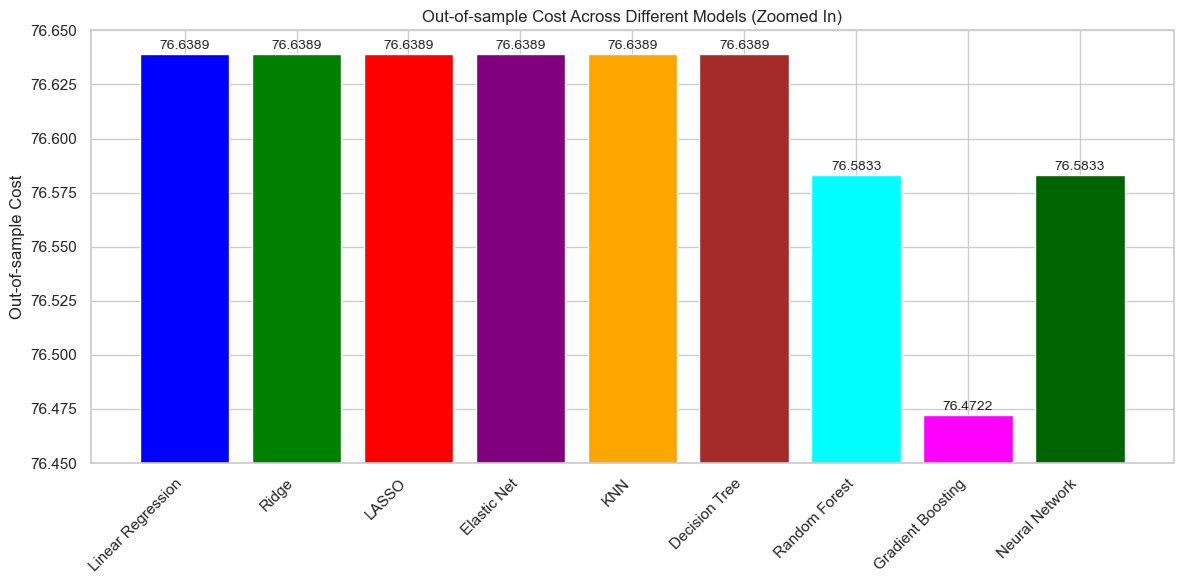

In [145]:
import matplotlib.pyplot as plt

# Models and their corresponding out-of-sample costs (from earlier)
models = [
    'Linear Regression', 'Ridge', 'LASSO', 'Elastic Net',
    'KNN', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Neural Network'
]

out_of_sample_cost = [
    76.6389, 76.6389, 76.6389, 76.6389,
    76.6389, 76.6389, 76.5833, 76.4722, 76.5833
]

# Define unique colors for each model
colors = [
    'blue', 'green', 'red', 'purple', 'orange',
    'brown', 'cyan', 'magenta', 'darkgreen'
]

# Create plot with zoomed-in y-axis
plt.figure(figsize=(12, 6))
bars = plt.bar(models, out_of_sample_cost, color=colors)

# Annotate each bar with the cost value
for bar, cost in zip(bars, out_of_sample_cost):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
             f'{cost:.4f}', ha='center', va='bottom', fontsize=10)

plt.ylim(76.45, 76.65)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Out-of-sample Cost')
plt.title('Out-of-sample Cost Across Different Models (Zoomed In)')
plt.tight_layout()
plt.show()


